In [2]:
"""
Train and test minimal predictive processing model to reproduce LZ and TE changes in
the depression state. The model consists of a Kalman filter trained on time series 
from the healthy subjects of the depressed dataset, and depression is modelled as 
a change in the prior and likelihood variance.

Pedro Mediano, Hardik Rajpal, Luka Dubravica, Modified July 2025
"""

#from glob import glob
from itertools import product
from lz76.lz76 import LZ76
from pykalman import KalmanFilter
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, decimate
from tqdm import tqdm

import functools
import h5py
import jpype
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys

project_root = os.getcwd()

In [3]:
def startJVM():
    """
    Start JVM using jpype, if not already running. Assumes the JIDT jar is in
    the current folder.
    """
    jarLocation = os.path.join(project_root, "infodynamics-dist-1.6.1", "infodynamics.jar")
    if not jpype.isJVMStarted():
        jpype.startJVM(jpype.getDefaultJVMPath(), "-ea","-Xmx1024m", "-Djava.class.path=" + jarLocation)


def TE(src, tgt, k=1, tau=1):
    """
    Computes transfer entropy using the JIDT Gaussian solver between two 1D
    time series.
    """
    startJVM()
    te_calc = jpype.JPackage("infodynamics.measures.continuous.gaussian").TransferEntropyCalculatorMultiVariateGaussian()
    te_calc.setProperty("DELAY",str(tau))
    te_calc.setProperty("K",str(k))
    te_calc.setProperty("L",str(k))
    te_calc.initialise(1, 1)
    te_calc.setObservations(src.tolist(), tgt.tolist())
    te_val = te_calc.computeAverageLocalOfObservations()
    return te_val


def simulate(x, f):
    """
    Given a KalmanFilter f and an input time series x, returns a tuple (s,o)
    where s are the filtered states and o are the model prediction errors.
    """
    s = f.filter(x)[0]
    o = (f.observation_matrices @ s.T).T 
    o = np.array(o)
    return (s.squeeze()[1:], o.squeeze()[1:] - x[1:])


def LZ(x):
    """
    Convenience wrapper function to compute normalised LZ of a time series
    after detrending and binarisation.
    """
    return LZ76(1*((x-np.mean(x)) > 0))*np.log(len(x))/len(x)


def copy_filter(kf, prior_factor=1, likelihood_factor=1):
    f = KalmanFilter(n_dim_state=kf.n_dim_state, n_dim_obs=kf.n_dim_obs,
                     initial_state_mean=kf.initial_state_mean,
                     initial_state_covariance = prior_factor*kf.initial_state_covariance,
                     transition_covariance = prior_factor*kf.transition_covariance,
                     observation_covariance = likelihood_factor*kf.observation_covariance,
                     em_vars = ['transition_matrices','observation_matrices'])
    return f


def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=1, axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis)
    return y


def load_subject_calcarine(eeg_source, sub_id, random_trials=True):
    '''
    Loads data from primary visual cortex (calcarine) for a given subject from the loaded MatLab dictionary.
    Data is of the shape (Time x AAL x Trials), where AAL is the number of AAL regions (24 for left calcarine, 25 for right calcarine).
    The function returns a numpy array of shape (Trials x Time) for the calcarine region.
    If random_trials is True, it randomly selects 10 trials from the available data.

    Parameters:
    - eeg_source: dict, loaded MatLab dictionary containing all subjects' data
    - sub_id: str, subject ID to extract data for
    - random_trials: bool, whether to select random trials or not
    Returns:
    - np.ndarray: shape (Trials x Time) for the calcarine region
    '''
    calcarine_idx = 24  # Index for the left calcarine region in AAL atlas (24 for left, 25 for right)
    normalise = lambda x: x/x.std()
    
    # Extract subject data: [samples * sources * trials]
    subject_data = eeg_source[sub_id]
    # Extract calcarine region data and transpose to [trials * samples]
    calcarine_data = subject_data[:, calcarine_idx, :].T
    
    # Select random trials and process data
    nb_trials = 10
    total_trials = calcarine_data.shape[0]
    
    if random_trials:
        idx = np.random.randint(total_trials, size=min(nb_trials, total_trials))
    else:
        idx = np.arange(min(nb_trials, total_trials))
    
    D = calcarine_data[idx]
    D_proc = []
    for i in range(len(D)): #Bandpass filtering for the data. Comment this out if data is already filtered
        filtered_data = butter_bandpass_filter(D[i,:], lowcut=1, highcut=100, fs=600, order=3)
        D_proc.append(normalise(filtered_data))
    
    return np.array(D_proc)  # Returns the processed data as a numpy array of shape (Trials x Time) for a given subject

In [ ]:
def model_run(eeg_source_data, subject_ids):
    df = []
    
    # Loop over each subject
    for z, sub_id in enumerate(tqdm(subject_ids)):
        # print(f"{z+1}/{len(subject_ids)}")
        
        # Loads filtered and normalised data of V1 calcarine region for the subject of shape (Trials x Time)
        D = load_subject_calcarine(eeg_source_data, sub_id, random_trials=True)
        
        ## Train baseline filter
        kf = KalmanFilter()
        for X in D:
            kf.em(X, n_iter=1)

        # Second round of training of baseline filter
        kf2 = copy_filter(kf)
        for X in D:
            kf2.em(X, n_iter=1)

        # Simulate predictions
        sim = [simulate(x, kf2) for x in D] # Get predicted states (frontal regions signal) and prediction errors (sensory regions signal)
        baseline_lz = np.mean([LZ(s[1]) for s in sim]) # LZ estimated for prediction errors
        # baseline_te = np.mean([TE(s[0], s[1], k=1) for s in sim]) # TE estimated from filtered states to prediction errors - front-to-back / top-down
        baseline_te = np.mean([TE(s[1], s[0], k=1) for s in sim]) # TE estimated from prediction errors to filtered states - back-to-front / bottom-up

        factor_vec = 2.0**np.arange(-5,6,1)
        
        for eta in factor_vec:
            # print(np.round(eta,2),end="...")

            # Try different prior and likelihood factors to match the LZ and TE changes in the Depressed condition.
            # Train one filter and then copy it with different prior/likelihood factors.
        
            ## Define model filter for depression
            prior_kf = copy_filter(kf, prior_factor=eta)
            likelihood_kf = copy_filter(kf, likelihood_factor=eta)
            # prior_factor=eta - increases prior variance - mimics overactive top-down priors
            # likelihood_factor=eta - increases likelihood variance - mimics overactive sensory trust (or weakened frontal control)

            ## Retrain the model with the same data, but with different prior/likelihood factors
            for X in D:
                prior_kf.em(X, n_iter=1)
                likelihood_kf.em(X, n_iter=1)
        
            ## Simulate and compute LZ+TE
            for t, x in enumerate(D):
                prior_sim = simulate(x, prior_kf)
                lz = LZ(prior_sim[1])
                # te = TE(prior_sim[0], prior_sim[1], k=1) # front-to-back / top-down
                te = TE(prior_sim[1], prior_sim[0], k=1) # back-to-front / bottom-up
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Prior Factor': eta, 'Likelihood Factor': eta,
                                        'Trial': t, 'LZ': lz, 'TE': te, 'Model': 'Prior'}, index=[0]))
                
                likelihood_sim = simulate(x, likelihood_kf)
                lz = LZ(likelihood_sim[1])
                # te = TE(likelihood_sim[0], likelihood_sim[1], k=1) # front-to-back / top-down
                te = TE(likelihood_sim[1], likelihood_sim[0], k=1) # back-to-front / bottom-up
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Prior Factor': eta, 'Likelihood Factor': eta,
                                        'Trial': t, 'LZ': lz, 'TE': te, 'Model': 'Likelihood'}, index=[0]))
        
                # Add baseline again, for convenience
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Prior Factor': eta, 'Likelihood Factor': eta,
                                        'Trial': t, 'LZ': baseline_lz, 'TE': baseline_te, 'Model': 'Baseline'}, index=[0]))
        # print("\n")
    
    return pd.concat(df, ignore_index=True)

In [5]:
print("Loading excel and matlab data...")

# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_excel = pd.read_excel(file_path, sheet_name=excel_sheet_name)
df_excel['depressed'] = df_excel['MDD'].apply(lambda x: 1 if x <= 2 else 0)

# Load all subjects' source reconstructed data from a matlab file
data_file = os.path.join(project_root, 'eeg_source.mat')
eeg_source = h5py.File(data_file, 'r')
eeg_source_open = eeg_source[f'eeg_source_open']
eeg_source_closed = eeg_source[f'eeg_source_closed']

# Get all subject IDs from the struct fields
healthy_subjects = df_excel[df_excel['depressed'] == 0]['id'].astype(str).values;
subject_ids = [key for key in eeg_source_open.keys() if key[1:] in healthy_subjects]
# subject_ids = subject_ids[:5] # TESTING
# Remove bad subject data
subject_ids = [sub_id for sub_id in subject_ids if sub_id not in ['x527', 'x535']]

# Run the model
print(f"Running open eyes model for {len(subject_ids)} subjects...")
df_single_open = model_run(eeg_source_open, subject_ids)
# df_single_open = model_run_parallel('open', subject_ids)
print(f"Running closed eyes model for {len(subject_ids)} subjects...")
df_single_closed = model_run(eeg_source_closed, subject_ids)
# df_single_closed = model_run_parallel('closed', subject_ids)

# Save the results to pickle files
with open('df_single_open.pkl', 'wb') as f:
    pickle.dump(df_single_open, f)
with open('df_single_closed.pkl', 'wb') as f:
    pickle.dump(df_single_closed, f)

Loading excel and matlab data...
Running open eyes model for 95 subjects...


100%|██████████| 95/95 [8:18:18<00:00, 314.72s/it]   


Running closed eyes model for 95 subjects...


100%|██████████| 95/95 [6:42:40<00:00, 254.32s/it]  


In [ ]:
# Load the results from pickle file
df_single_open = None
with open('df_single_open.pkl', 'rb') as f:
    df_single_open = pickle.load(f)

df_single_closed = None
with open('df_single_closed.pkl', 'rb') as f:
    df_single_closed = pickle.load(f)

## Data Display

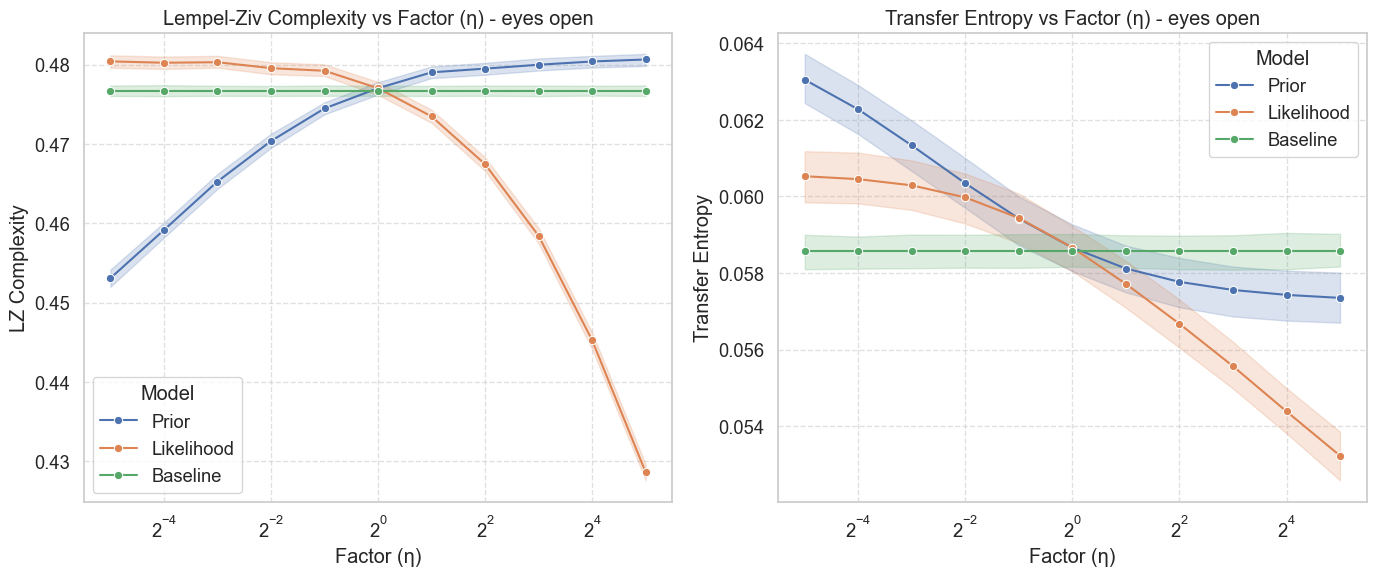

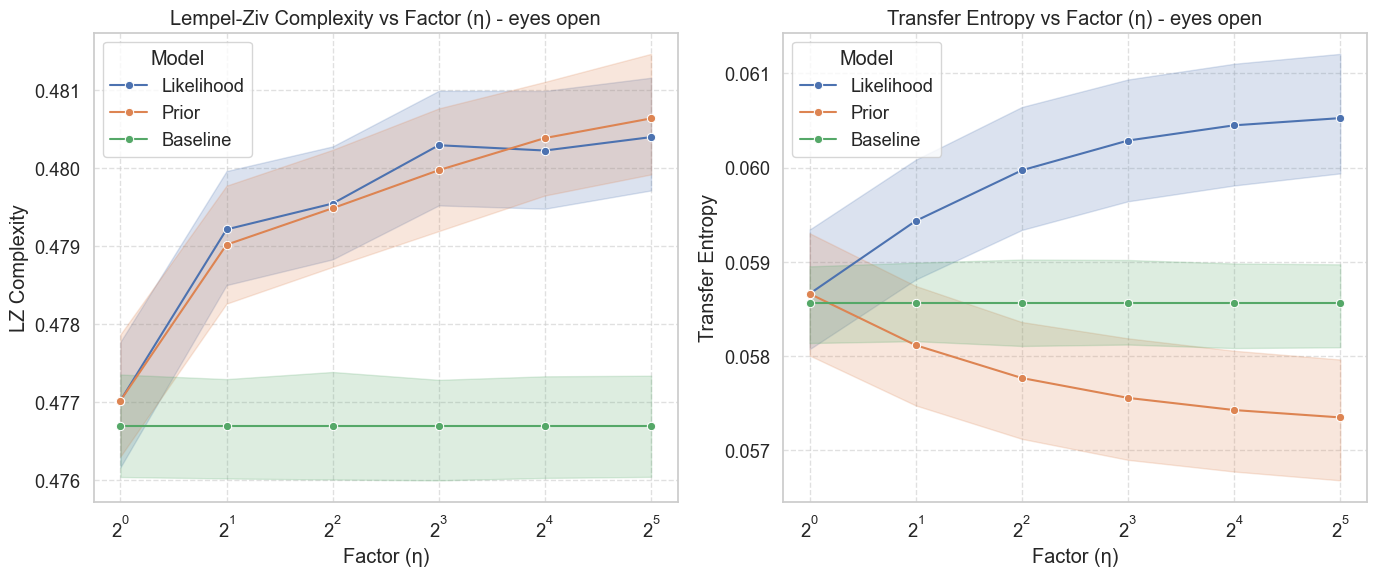

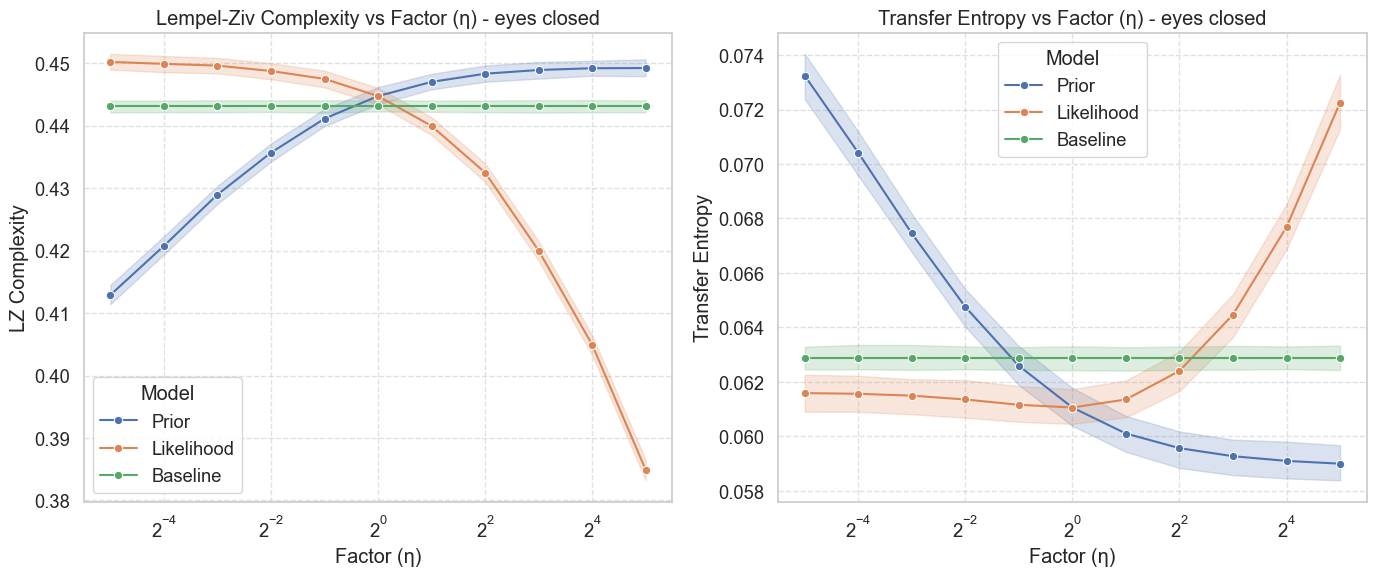

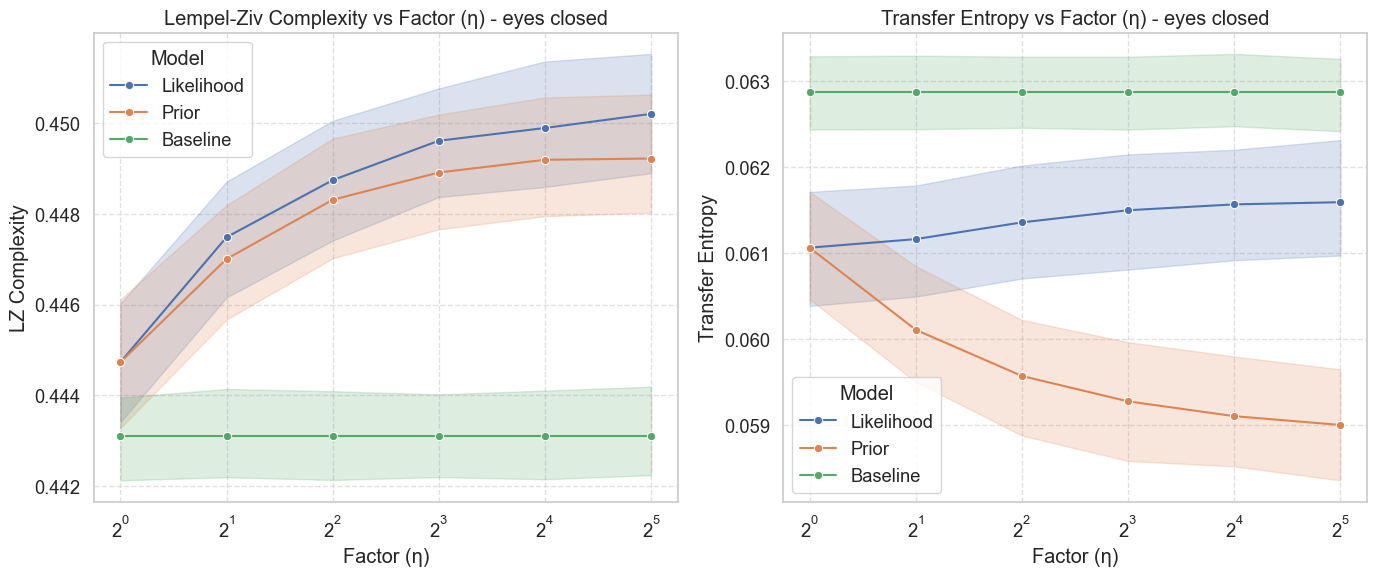

In [ ]:
df = df_single_open.copy()

def plot_df(df, eyes):

    df['Factor'] = df['Prior Factor'].fillna(df['Likelihood Factor'])

    sns.set_theme(style="whitegrid", font_scale=1.2)

    # TOP PLOT

    # Create subplots: one for LZ, one for TE
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Plot LZ vs Prior Factor with error bars
    sns.lineplot(data=df, x='Factor', y='LZ', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[0])
    axs[0].set_title('Lempel-Ziv Complexity vs Factor (η) - eyes ' + eyes)
    axs[0].set_xscale('log', base=2)
    axs[0].set_xlabel('Factor (η)')
    axs[0].set_ylabel('LZ Complexity')

    # Plot TE vs Prior Factor with error bars
    sns.lineplot(data=df, x='Factor', y='TE', hue='Model', marker='o',
                errorbar=('ci', 60), ax=axs[1])
    axs[1].set_title('Transfer Entropy vs Factor (η) - eyes ' + eyes)
    axs[1].set_xscale('log', base=2)
    axs[1].set_xlabel('Factor (η)')
    axs[1].set_ylabel('Transfer Entropy')

    # Formatting
    for ax in axs:
        ax.legend(title='Model')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # BOTTOM PLOT

    df_likelihood = df.loc[df['Model'] == 'Likelihood'].loc[df['Factor'] <= 1].copy()
    df_likelihood.loc[:, 'Factor'] = 1 / df_likelihood['Factor'].values
    df_likelihood.loc[:, 'Model'] = 'Likelihood'

    df_prior = df.loc[df['Model'] == 'Prior'].loc[df['Factor'] >= 1].copy()
    df_prior.loc[:, 'Model'] = 'Prior'

    df_base = df.loc[df['Model'] == 'Baseline'].loc[df['Factor'] >= 1].copy()

    df_all = pd.concat([df_likelihood, df_prior, df_base], ignore_index=True)

    # Create subplots: one for LZ, one for TE
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Plot LZ vs Prior Factor with error bars
    sns.lineplot(data=df_all, x='Factor', y='LZ', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[0])
    axs[0].set_title('Lempel-Ziv Complexity vs Factor (η) - eyes ' + eyes)
    axs[0].set_xscale('log', base=2)
    axs[0].set_xlabel('Factor (η)')
    axs[0].set_ylabel('LZ Complexity')

    # Plot TE vs Prior Factor with error bars
    sns.lineplot(data=df_all, x='Factor', y='TE', hue='Model', marker='o',
                errorbar=('ci', 60), ax=axs[1])
    axs[1].set_title('Transfer Entropy vs Factor (η) - eyes ' + eyes)
    axs[1].set_xscale('log', base=2)
    axs[1].set_xlabel('Factor (η)')
    axs[1].set_ylabel('Transfer Entropy')

    # Formatting
    for ax in axs:
        ax.legend(title='Model')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_df(df_single_open, 'open')
plot_df(df_single_closed, 'closed')

In [17]:
# Calculate mean LZ and TE for each Model and Factor combination
df_summary = df.groupby(['Model', 'Prior Factor']).agg({
    'LZ': 'mean',
    'TE': 'mean'
}).reset_index()

# Print the results
for model in ['Baseline', 'Likelihood', 'Prior']:
    print(f"\n{model} Model:")
    model_data = df_summary[df_summary['Model'] == model]
    for _, row in model_data.iterrows():
        print(f"  Factor {row['Prior Factor']:8.5f}: LZ = {row['LZ']:.6f}, TE = {row['TE']:.6f}")


Baseline Model:
  Factor  0.03125: LZ = 0.476696, TE = 0.058566
  Factor  0.06250: LZ = 0.476696, TE = 0.058566
  Factor  0.12500: LZ = 0.476696, TE = 0.058566
  Factor  0.25000: LZ = 0.476696, TE = 0.058566
  Factor  0.50000: LZ = 0.476696, TE = 0.058566
  Factor  1.00000: LZ = 0.476696, TE = 0.058566
  Factor  2.00000: LZ = 0.476696, TE = 0.058566
  Factor  4.00000: LZ = 0.476696, TE = 0.058566
  Factor  8.00000: LZ = 0.476696, TE = 0.058566
  Factor 16.00000: LZ = 0.476696, TE = 0.058566
  Factor 32.00000: LZ = 0.476696, TE = 0.058566

Likelihood Model:
  Factor  0.03125: LZ = 0.480402, TE = 0.060526
  Factor  0.06250: LZ = 0.480230, TE = 0.060450
  Factor  0.12500: LZ = 0.480298, TE = 0.060288
  Factor  0.25000: LZ = 0.479549, TE = 0.059972
  Factor  0.50000: LZ = 0.479217, TE = 0.059435
  Factor  1.00000: LZ = 0.477020, TE = 0.058663
  Factor  2.00000: LZ = 0.473466, TE = 0.057715
  Factor  4.00000: LZ = 0.467434, TE = 0.056675
  Factor  8.00000: LZ = 0.458405, TE = 0.055567
  Fa